&emsp;&emsp;在理解了神经元线性模型的原理以及各种优化算法以后，我们来实战训练单输入神经元线性模型。

&emsp;&emsp;首先我们引入需要的包。

In [1]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt
# cal y = 1.477x + 0.089 + epsilon,epsilon ~ N(0, 0.01^2)

**1. 生成数据集**

&emsp;&emsp;我们需要采样自真实模型的多组数据，对于已知真实模型的 **玩具样例** (Toy Example)，我们直接从指定的 $w = 1.477 , b = 0.089$ 的真实模型中直接采样：
$$
y=1.477 \times x+0.089
$$



&emsp;&emsp;为了能够很好地模拟真实样本的观测误差，我们给模型添加误差自变量 $\epsilon$ ，它采样自均值为 $0$ ，方差为 $0.01$ 的高斯分布：
$$
y=1.477 x+0.089+\epsilon, \epsilon \sim \mathcal{N}(0,0.01)
$$

&emsp;&emsp;我们通过随机采样 $n = 100$ 次，我们获得 $n$ 个样本的训练数据集 $\mathbb D_{\mathrm{train}}$ ，然后循环进行 $100$ 次采样，每次从均匀分布 $U ( -10,10)$ 中随机采样一个数据 $x$ 同时从均值为 $0$ ，方差为 $0.1^{2}$ 的高斯分布 $\mathcal{N}\left(0,0.1^{2}\right)$ 中随机采样噪声 $\epsilon$，根据真实模型生成 $y$ 的数据，并保存为 $\text{Numpy}$ 数组。

In [2]:
def get_data():
    # 计算均方误差
    #保存样本集的列表
    data = [] 
    for i in range(100):
        x = np.random.uniform(-10., 10.)  # 随机采样 x
        # 高斯噪声
        eps = np.random.normal(0., 0.01) # 均值和方差
        # 得到模型的输出
        y = 1.477 * x + 0.089 + eps
        # 保存样本点
        data.append([x, y]) 
    # 转换为2D Numpy数组
    data = np.array(data)  
    return data

**2. 计算误差**

&emsp;&emsp;循环计算在每个点 $\left(x^{(i)}, y^{(i)}\right)$ 处的预测值与真实值之间差的平方并累加，从而获得训练集上的均方差损失值。

&emsp;&emsp;最后的误差和除以数据样本总数，从而得到每个样本上的平均误差。

In [3]:
def mse(b, w, points) :
    totalError = 0
    # 根据当前的w，b参数计算均方差损失
    for i in range(0, len(points)) : # 循环迭代所有点
        # 获得 i 号点的输入 x
        x = points[i, 0]
        # 获得 i 号点的输出 y
        y = points[i, 1]
        # 计算差的平方，并累加
        totalError += (y - (w * x + b)) ** 2
    # 将累加的误差求平均，得到均方误差
    return totalError / float(len(points))

**3. 计算梯度**

&emsp;&emsp;这里我们使用更加简单好用的梯度下降算法。我们需要计算出函数在每一个点上的梯度信息： $\left(\dfrac{\partial \mathcal{L}}{\partial w}, \dfrac{\partial \mathcal{L}}{\partial b}\right)$。我们来推导一下梯度的表达式，首先考虑 $\dfrac{\partial \mathcal{L}}{\partial w}$ ，将均方差函数展开： 

$$
\begin{aligned}\frac{\displaystyle \partial \mathcal{L}}{\partial w}&=\frac{\displaystyle \partial \frac{1}{n} \sum_{i=1}^{n}\left(w x^{(i)}+b-y^{(i)}\right)^{2}}{\partial w}&\\&=\frac{1}{n} \sum_{i=1}^{n} \frac{\partial\left(w x^{(i)}+b-y^{(i)}\right)^{2}}{\partial w}\end{aligned}
$$

由于：

$$
\frac{\partial g^{2}}{\partial w}=2 \cdot g \cdot \frac{\partial g}{\partial w}
$$

则有：

$$
\begin{aligned}\frac{\partial \mathcal{L}}{\partial w}&=\frac{1}{n} \sum_{i=1}^{n} 2\left(w x^{(i)}+b-y^{(i)}\right) \cdot \frac{\partial\left(w x^{(i)}+b-y^{(i)}\right)}{\partial w} &\\&=\frac{1}{n} \sum_{i=1}^{n} 2\left(w x^{(i)}+b-y^{(i)}\right) \cdot x^{(i)} &\\&=\frac{2}{n} \sum_{i=1}^{n}\left(w x^{(i)}+b-y^{(i)}\right) \cdot x^{(i)}\end{aligned}
$$


$$
\begin{aligned}\dfrac{\partial \mathcal{L}}{\partial b}&=\dfrac{\displaystyle \partial \dfrac{1}{n} \sum_{i=1}^{n}\left(w x^{(i)}+b-y^{(i)}\right)^{2}}{\partial b}\\&=\frac{1}{n} \sum_{i=1}^{n} \frac{\partial\left(w x^{(i)}+b-y^{(i)}\right)^{2}}{\partial b} &\\&=\frac{1}{n} \sum_{i=1}^{n} 2\left(w x^{(i)}+b-y^{(i)}\right) \cdot \frac{\partial\left(w x^{(i)}+b-y^{(i)}\right)}{\partial b} &\\&=\frac{1}{n} \sum_{i=1}^{n} 2\left(w x^{(i)}+b-y^{(i)}\right) \cdot 1 &\\&=\frac{2}{n} \sum_{i=1}^{n}\left(w x^{(i)}+b-y^{(i)}\right)\end{aligned}
$$

&emsp;&emsp;根据上面偏导数的表达式，我们只需要计算在每一个点上面的 $\left(w x^{(i)}+b-y^{(i)}\right)$ 和 $\left(w x^{(i)}+b-y^{(i)}\right)$ 值，平均后即可得到偏导数 $\dfrac{\partial \mathcal{L}}{\partial w}$ 和 $\dfrac{\partial \mathcal{L}}{\partial b}$ 。 

In [4]:
# 计算偏导数
def step_gradient(b_current, w_current, points, lr) :
    # 计算误差函数在所有点上的异数，并更新w，b
    b_gradient = 0
    w_gradient = 0
    # 总体样本
    M = float(len(points))
    for i in range(0, len(points)) :
        x = points[i, 0]
        y = points[i, 1]
        # 偏b
        b_gradient += (2 / M) * ((w_current * x + b_current) - y)
        # 偏w
        w_gradient += (2 / M) * x * ((w_current * x + b_current) - y)
    # 根据梯度下降算法更新的 w',b',其中lr为学习率
    new_b = b_current - (lr * b_gradient)
    new_w = w_current - (lr * w_gradient)
    return [new_b, new_w]
    
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = ['STKaiti']
plt.rcParams['axes.unicode_minus'] = False

# 梯度更新
def gradient_descent(points, starting_b, starting_w, lr, num_iterations) :
    b = starting_b
    w = starting_w
    MSE = []
    Epoch = []
    for step in range(num_iterations) :
        b, w = step_gradient(b, w, np.array(points), lr)
        # 计算当前的均方误差，用于监控训练进度
        loss = mse(b, w, points)
        MSE.append(loss)
        Epoch.append(step)
        if step % 50 == 0 :
            print(f"iteration:{step}, loss:{loss}, w:{w}, b:{b}")
    plt.plot(Epoch, MSE, color='C1', label='均方差')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('MSE function')
    plt.legend(loc = 1)
    plt.show()
    return [b, w] 

**4. 主函数**



iteration:0, loss:8.52075121569461, w:0.9683621336270813, b:0.018598967590321615
iteration:50, loss:0.0005939300597845278, w:1.477514542941938, b:0.06613823978315139
iteration:100, loss:0.00016616611251547874, w:1.4772610937560182, b:0.08026637756911292
iteration:150, loss:0.00010824080152649426, w:1.4771678278317757, b:0.08546534407456151
iteration:200, loss:0.00010039689211198855, w:1.4771335072140424, b:0.08737849449355252
iteration:250, loss:9.933471542527609e-05, w:1.4771208776838989, b:0.08808250836281861
iteration:300, loss:9.919088162325623e-05, w:1.477116230185043, b:0.08834157608859644
iteration:350, loss:9.917140448460003e-05, w:1.4771145199673728, b:0.08843690956066241
iteration:400, loss:9.916876700352793e-05, w:1.477113890630052, b:0.08847199100845321
iteration:450, loss:9.916840985114966e-05, w:1.4771136590423013, b:0.08848490051392309
iteration:500, loss:9.916836148764827e-05, w:1.4771135738210939, b:0.08848965103996947
iteration:550, loss:9.916835493854371e-05, w:1.477

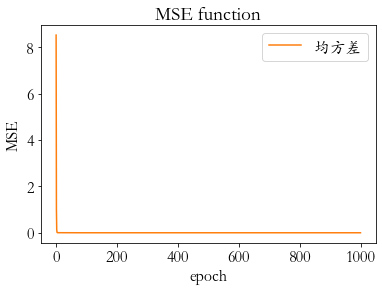

Final loss:9.916835391280157e-05, w1.4771135242037658, b0.08849241688214672


In [5]:
def solve(data) :
    # 学习率
    lr = 0.01
    initial_b = 0
    initial_w = 0
    num_iterations = 1000
    [b, w] = gradient_descent(data, initial_b, initial_w, lr, num_iterations)
    loss = mse(b, w, data)
    print(f'Final loss:{loss}, w{w}, b{b}')

if __name__ == "__main__": 
    data = get_data() 
    solve(data)